In [26]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [27]:
students1 = pd.read_csv('student-mat.csv')
students1.dataframeName = 'student-mat.csv'
print(students1.shape)

students2 = pd.read_csv('student-por.csv')
print(students2.shape)

#MERGE AND REMOVE DUPLS

(395, 33)
(649, 33)


In [28]:
print(students1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [29]:
cols = list(students1.columns)
print(cols)

['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


In [30]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(int(nGraphRow), nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

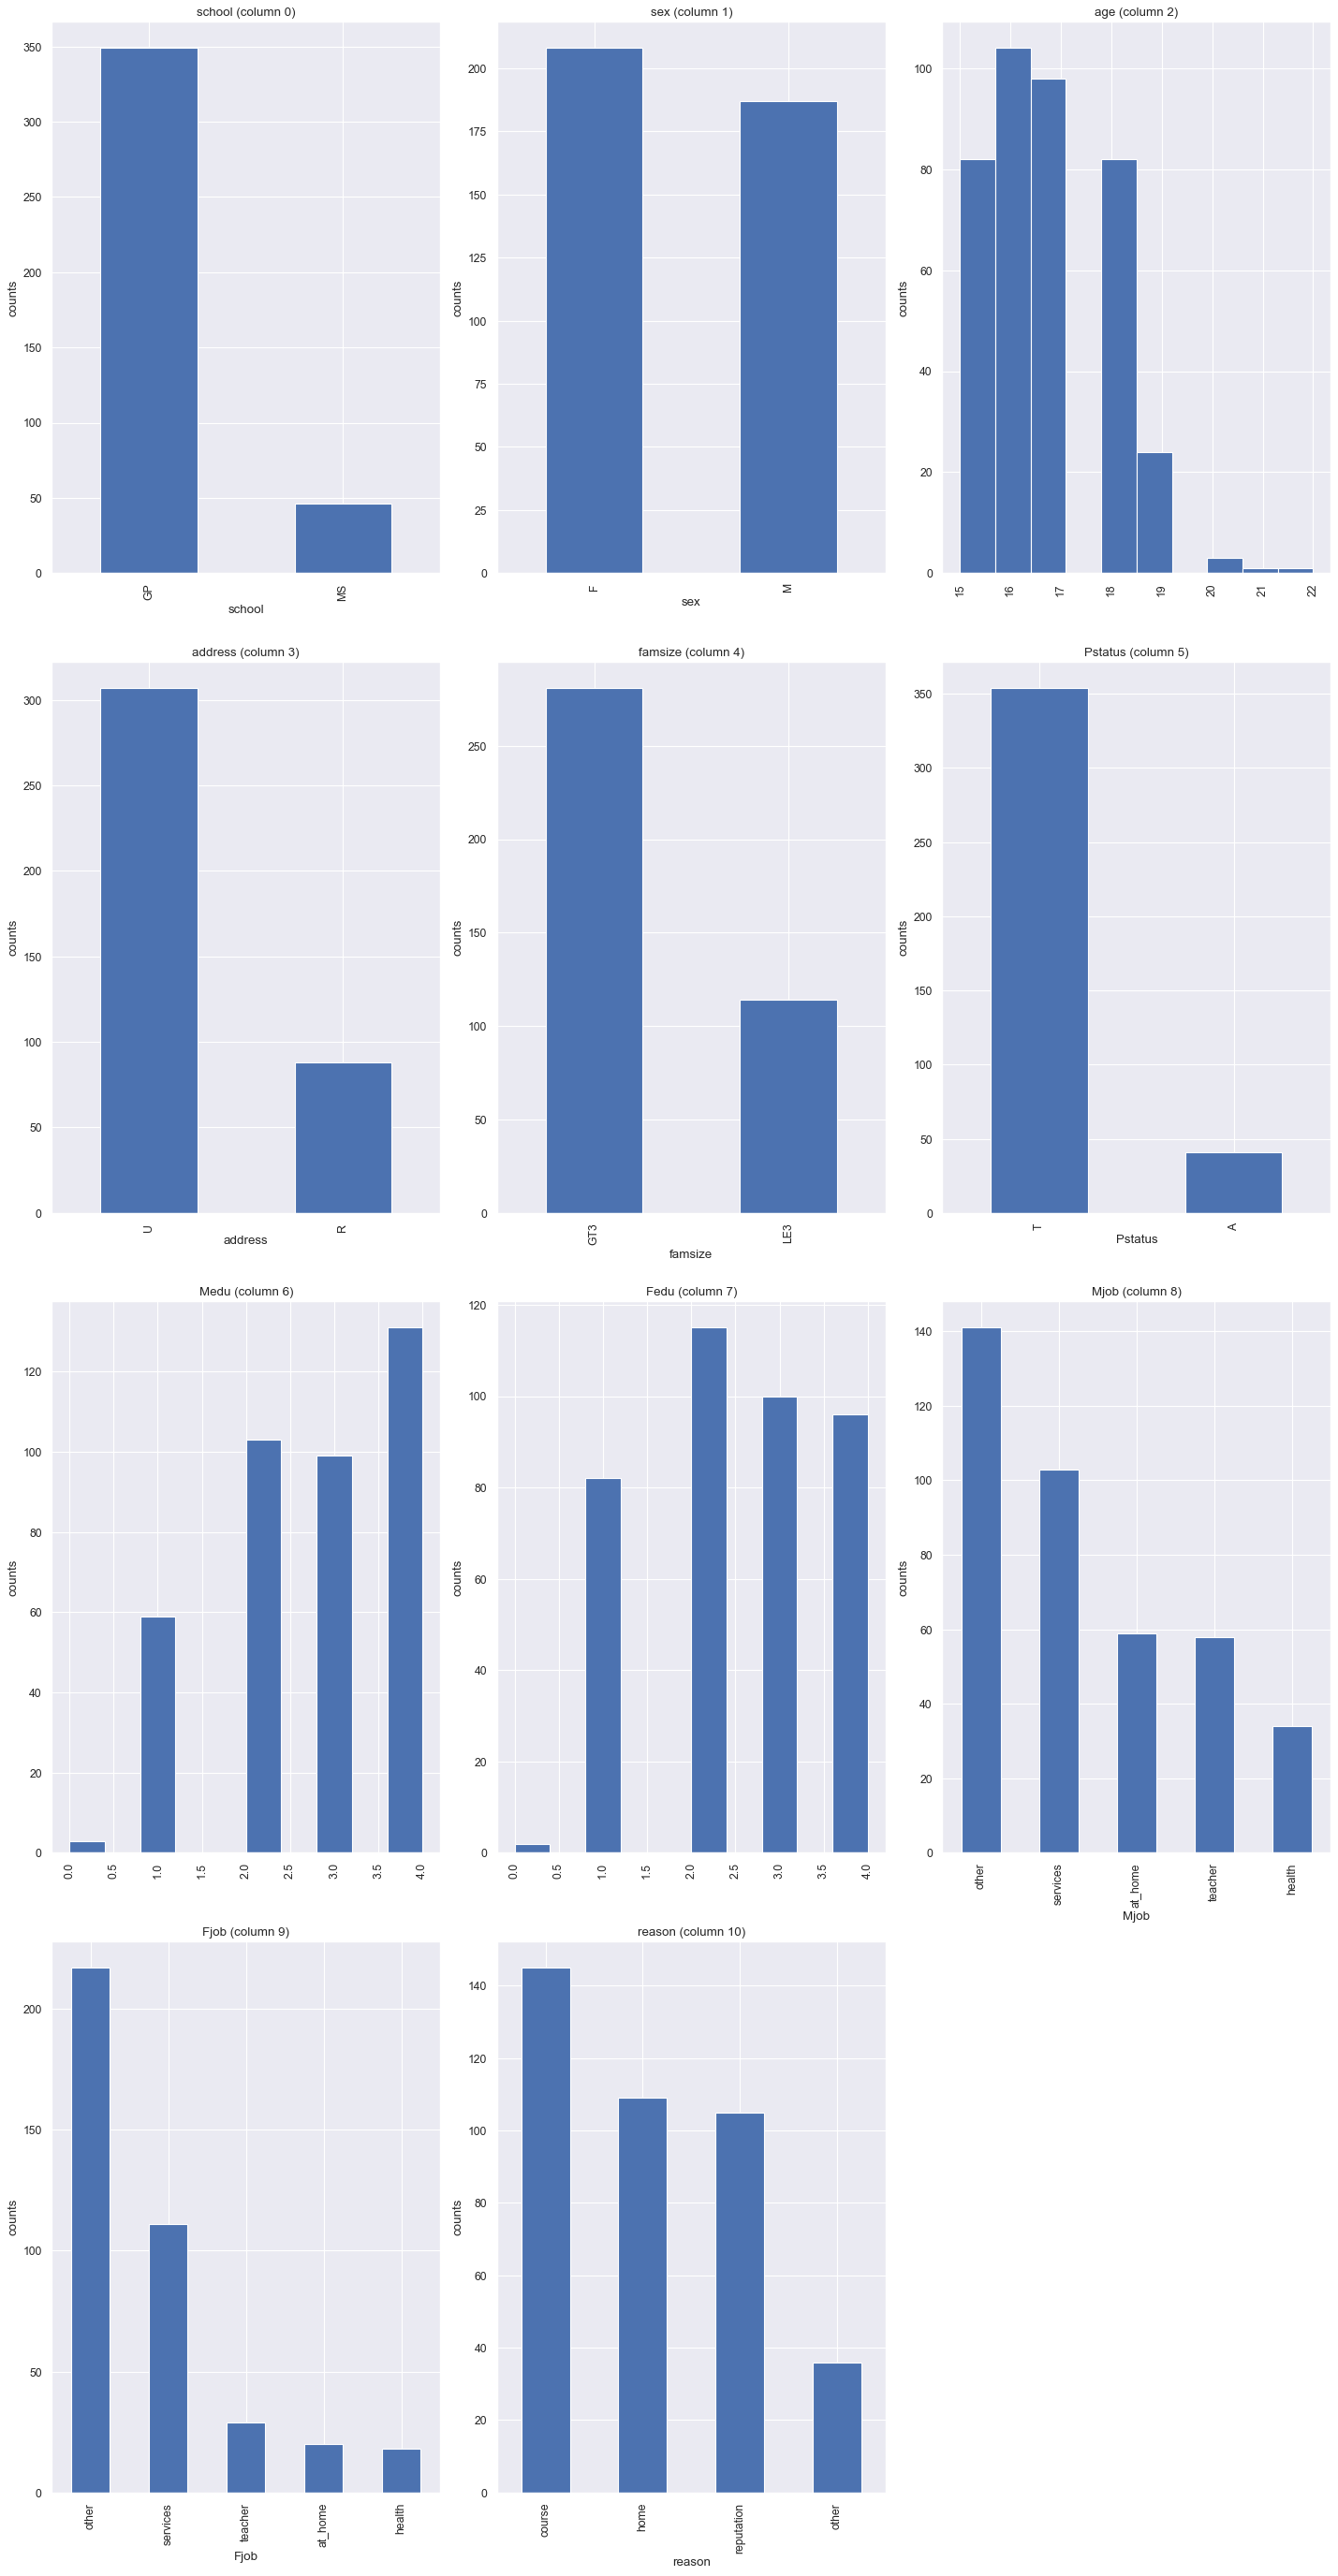

In [31]:
plotPerColumnDistribution(students1, 11, 3)

In [32]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    #df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for Student Alcohol Consumption', fontsize=15)
    plt.show()

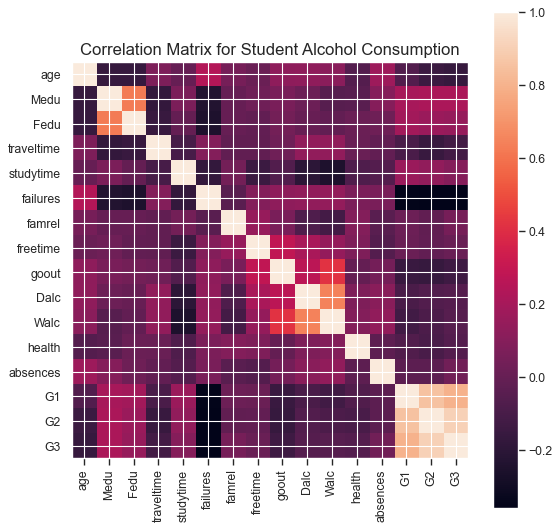

In [34]:
newDF = students1.select_dtypes(include=np.number)
newDF.dataframeName = 'student-mat.csv'
plotCorrelationMatrix(newDF, 8)

In [35]:
#MERGE DALC AND WALC?? 0 AND 1 
#GROUP COLS TO FIND RELEVANCY

In [36]:
#merging dataframes
students1_new = students1.drop(columns = ['G1','G2','G3'])
students2_new = students2.drop(columns = ['G1','G2','G3'])
students = pd.concat([students1_new, students2_new], axis=0)
students.info()



<class 'pandas.core.frame.DataFrame'>
Index: 1044 entries, 0 to 648
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nursery     1044 non-null   object
 20  higher      10

In [37]:
students = students.drop_duplicates(ignore_index= True)

In [38]:
students['id'] = range(1, len(students) + 1)
students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,id
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,3
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,4
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,5


In [39]:
dictionary = {}
for i in range(len(students)):
    #dictionary[i] = 'NaN'
    dalc = students.at[i, "Dalc"]
    walc = students.at[i, "Walc"]
    if (dalc >= 4 or walc >= 4):
        dictionary[i] = 1
    else:
        dictionary[i] = 0
        
print(dictionary)

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 0, 21: 0, 22: 0, 23: 1, 24: 0, 25: 0, 26: 0, 27: 1, 28: 0, 29: 1, 30: 1, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 1, 42: 0, 43: 0, 44: 0, 45: 0, 46: 1, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 1, 53: 0, 54: 1, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 1, 62: 0, 63: 1, 64: 1, 65: 0, 66: 1, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 1, 73: 0, 74: 1, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 1, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 1, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 1, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 1, 119: 0, 120: 0, 121: 0, 122: 0, 123: 1, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 1, 130: 0, 131: 0, 132: 0, 133: 1, 134: 0, 135: 0, 136: 1, 137: 0, 138: 

In [40]:
dictionary = {}
for i, row in students.iterrows():
    dalc = row["Dalc"]
    walc = row["Walc"]
    if (dalc >= 4 or walc >= 4):
        dictionary[i] = 1
    else:
        dictionary[i] = 0
        
print(dictionary)

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 1, 19: 0, 20: 0, 21: 0, 22: 0, 23: 1, 24: 0, 25: 0, 26: 0, 27: 1, 28: 0, 29: 1, 30: 1, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 1, 42: 0, 43: 0, 44: 0, 45: 0, 46: 1, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 1, 53: 0, 54: 1, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 1, 62: 0, 63: 1, 64: 1, 65: 0, 66: 1, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 1, 73: 0, 74: 1, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 1, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 1, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 1, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 1, 119: 0, 120: 0, 121: 0, 122: 0, 123: 1, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 1, 130: 0, 131: 0, 132: 0, 133: 1, 134: 0, 135: 0, 136: 1, 137: 0, 138: 

In [41]:
students['alc'] = 0  # Initialize the new column with default values

for i in range(len(students)):
    if (students.iloc[i]['Dalc'] >= 4 or students.iloc[i]['Walc'] >= 4):
        students.at[i, 'alc'] = 1
    else:
        students.at[i, 'alc'] = 0

In [42]:
students.head(50)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,id,alc
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,1,1,3,6,1,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,no,5,3,3,1,1,3,4,2,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,no,4,3,2,2,3,3,10,3,0
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,3,2,2,1,1,5,2,4,0
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,4,3,2,1,2,5,4,5,0
5,GP,M,16,U,LE3,T,4,3,services,other,...,no,5,4,2,1,2,5,10,6,0
6,GP,M,16,U,LE3,T,2,2,other,other,...,no,4,4,4,1,1,3,0,7,0
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,no,4,1,4,1,1,1,6,8,0
8,GP,M,15,U,LE3,A,3,2,services,other,...,no,4,2,2,1,1,1,0,9,0
9,GP,M,15,U,GT3,T,3,4,other,other,...,no,5,5,1,1,1,5,0,10,0


In [43]:

from sklearn.preprocessing import StandardScaler, LabelEncoder 

categorical_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

#duplicate students dataframe
students1 = students.copy()
students1.drop(['Dalc', 'Walc'], axis=1, inplace=True) # remove dalc and walc columns and modify original DataFrame

# one hot encode the categorical columns
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    students1[col] = label_encoders[col].fit_transform(students[col])

students1.head(20)



,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,health,absences,id,alc
0,0,0,18,1,0,0,4,4,0,4,...,1,0,0,4,3,4,3,6,1,0
1,0,0,17,1,0,1,1,1,0,2,...,1,1,0,5,3,3,3,4,2,0
2,0,0,15,1,1,1,1,1,0,2,...,1,1,0,4,3,2,3,10,3,0
3,0,0,15,1,0,1,4,2,1,3,...,1,1,1,3,2,2,5,2,4,0
4,0,0,16,1,0,1,3,3,2,2,...,1,0,0,4,3,2,5,4,5,0
5,0,1,16,1,1,1,4,3,3,2,...,1,1,0,5,4,2,5,10,6,0
6,0,1,16,1,1,1,2,2,2,2,...,1,1,0,4,4,4,3,0,7,0
7,0,0,17,1,0,0,4,4,2,4,...,1,0,0,4,1,4,1,6,8,0
8,0,1,15,1,1,0,3,2,3,2,...,1,1,0,4,2,2,1,0,9,0
9,0,1,15,1,0,1,3,4,2,2,...,1,1,0,5,5,1,5,0,10,0


In [44]:
fam_columns = ['Medu', 'Fedu', 'famrel', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'guardian', 'famsup']
grades_columns = ['failures', 'absences', 'schoolsup', 'paid', 'nursery', 'higher']
char_columns = ['age', 'health', 'sex']
lifestyle_columns = ['traveltime', 'studytime', 'freetime', 'goout', 'school', 'address', 'reason', 'activities', 'internet', 'romantic']


family = students1[fam_columns].copy()
grades = students1[grades_columns].copy()
char = students1[char_columns].copy()
lifestyle = students1[lifestyle_columns].copy()

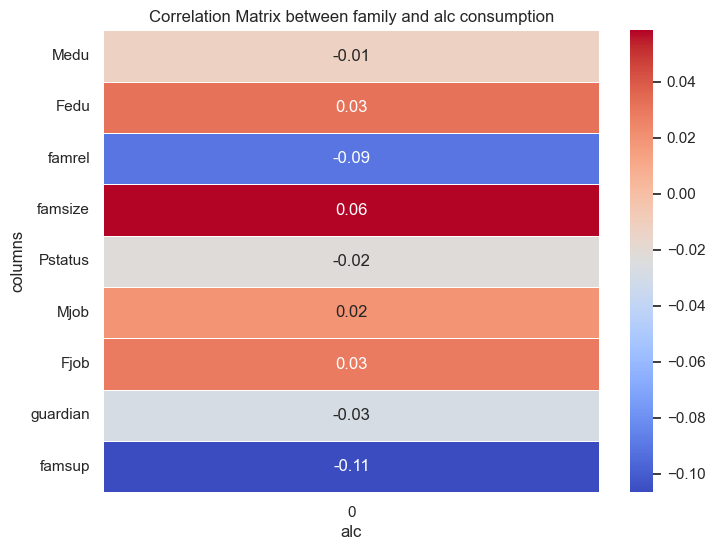

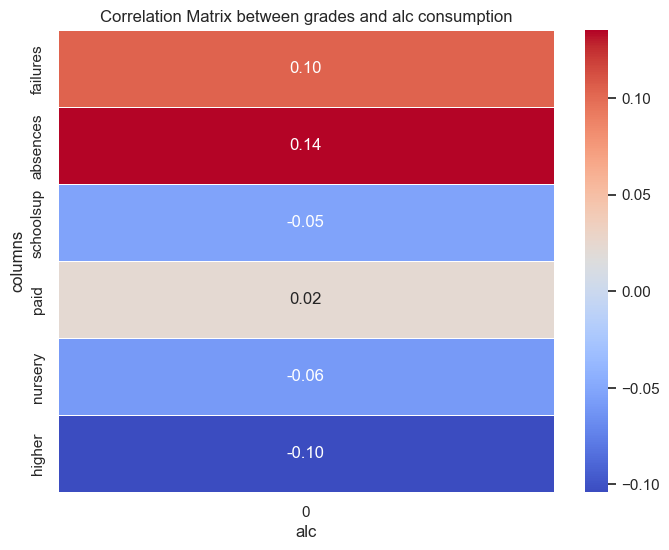

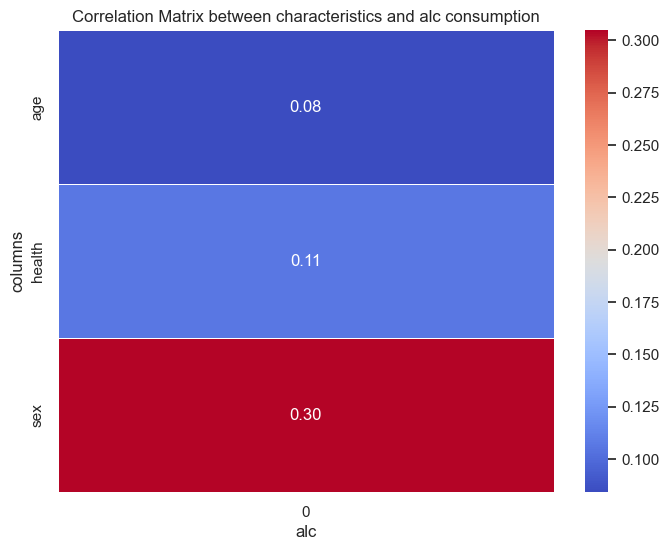

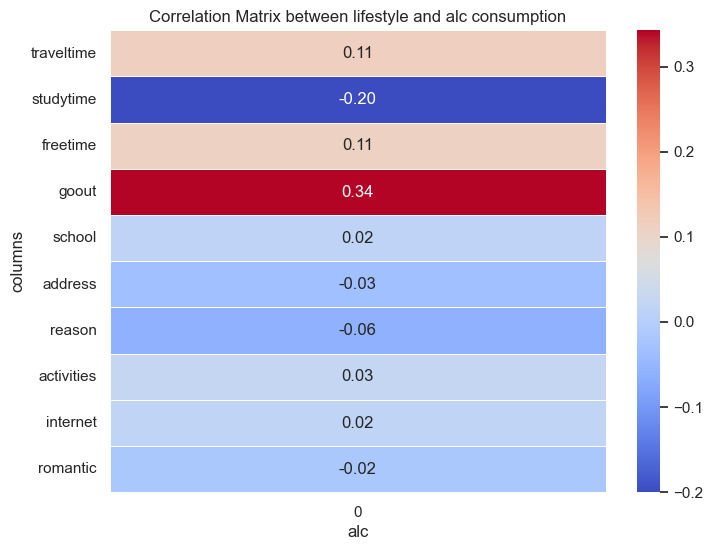

In [45]:
# Extract the single variable column from df2
alcohol_consumption = students1['alc']

#FAMILY
# Calculate correlation coefficients
correlation_matrix = family.corrwith(alcohol_consumption)

# Plot correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix between family and alc consumption")
plt.xlabel("alc")
plt.ylabel("columns")
plt.show()

#GRADES
# Calculate correlation coefficients
correlation_matrix = grades.corrwith(alcohol_consumption)

# Plot correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix between grades and alc consumption")
plt.xlabel("alc")
plt.ylabel("columns")
plt.show()

#CHAR
# Calculate correlation coefficients
correlation_matrix = char.corrwith(alcohol_consumption)

# Plot correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix between characteristics and alc consumption")
plt.xlabel("alc")
plt.ylabel("columns")
plt.show()

#LIFESTYLE
# Calculate correlation coefficients
correlation_matrix = lifestyle.corrwith(alcohol_consumption)

# Plot correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix between lifestyle and alc consumption")
plt.xlabel("alc")
plt.ylabel("columns")
plt.show()

In [46]:
from scipy.stats import chi2_contingency
cross_tab=pd.crosstab(index=students1['absences'],columns=students1['alc'])
print(cross_tab)


alc         0   1
absences         
0         282  53
1          12   3
2         141  30
3          12   3
4         114  28
5          15   2
6          60  18
7          10   0
8          41  21
9           8   2
10         28   8
11          5   3
12         15   9
13          0   4
14         13   6
15          3   2
16          8   9
17          1   0
18          5   3
19          0   1
20          3   1
21          2   1
22          2   3
23          1   0
24          2   0
25          1   0
26          2   0
28          0   1
30          1   1
32          1   0
38          1   0
40          1   0
54          0   1
56          1   0
75          1   0


In [49]:
# present the above data better
# update the sets of columns
# what areas of a student's life are more likely to affect the likeliness of them having alcoholic tendencies

# models:
# https://scikit-learn.org/stable/supervised_learning.html
# nearest neighbours, svm, nb
# https://visualstudiomagazine.com/articles/2023/03/01/naive-bayes-scikit.aspx

# 1-4-2024
# model weights and tuning
# compare all
# where are the categoricals??
# extract siignificnce of columns - like p values below

In [50]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
absences = students1['goout'].array.reshape(-1, 1)
neigh.fit(absences, students1['alc'])
print(neigh.predict(np.array([[5]]).reshape(1, -1)))
# try multiple predictors

[1]


In [51]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

#iris = load_iris(as_frame=True)
X = students1[["absences", "alc"]]
y = X['alc']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Chi-Square Test

We used this test to map correlation because most of the columns are categorical, and the chi-square test ...

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
)

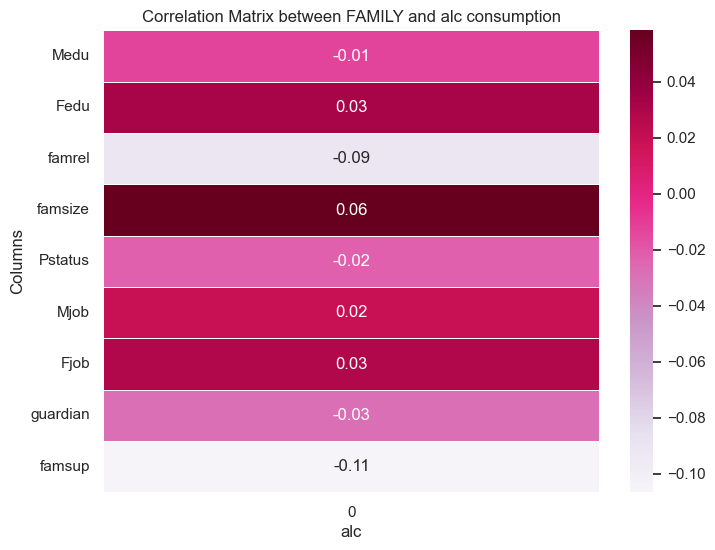

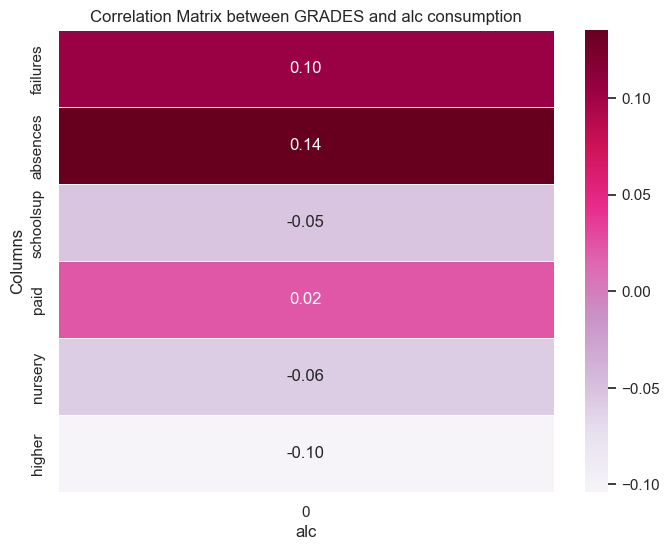

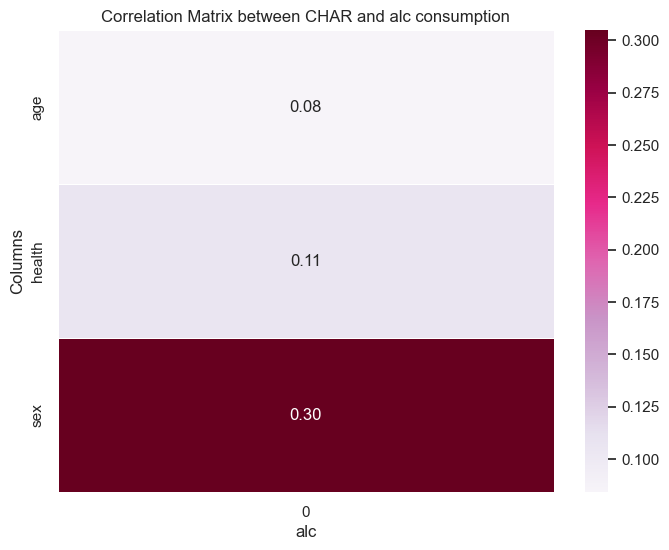

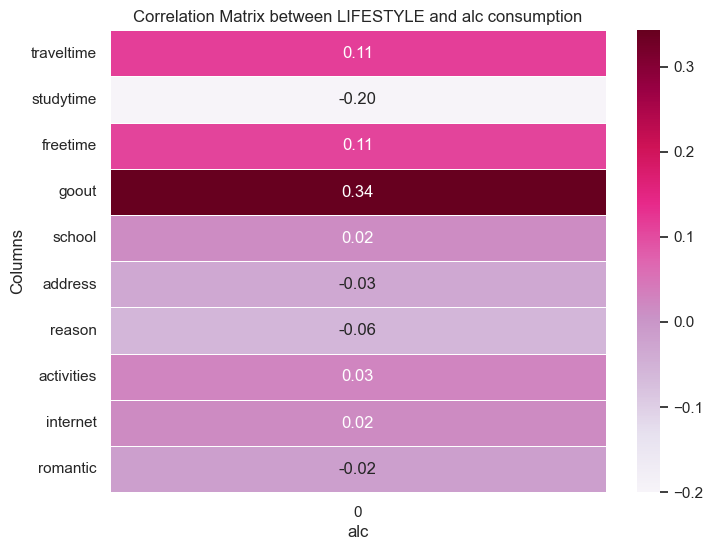

NameError: name 'list' is not defined

In [55]:
# chi squared test for correlation matrix

import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

# Extract the single variable column from df2
alcohol_consumption = students1['alc']

# Define subsets of your data
data_subsets = {'FAMILY': family, 'GRADES': grades, 'CHAR': char, 'LIFESTYLE': lifestyle}

# Plot correlation matrices for each subset
for subset_name, subset_data in data_subsets.items():
    # Calculate correlation coefficients
    correlation_matrix = subset_data.corrwith(alcohol_consumption)

    # Plot correlation matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sb.heatmap(correlation_matrix.to_frame(), annot=True, cmap='PuRd', fmt=".2f", linewidths=.5)
    plt.title(f"Correlation Matrix between {subset_name} and alc consumption")
    plt.xlabel("alc")
    plt.ylabel("Columns")
    plt.show()

# Use a loop to plot correlation with ...
del list
cols = list(students1.columns)
for col in cols:
    if col in ['id', 'alc']:
        continue
    cross_tab = pd.crosstab(index=students1[col], columns=students1['alc']) 
    chi_sq_result = chi2_contingency(cross_tab) # this is the chi square test
    p, x = chi_sq_result[1], "reject" if chi_sq_result[1] < 0.05 else "accept"
    # best p values and columns
    if p < 0.01:
        print(f"For {col} against alcohol consumption, the p-value is {chi_sq_result[1]} and hence we {x} the null hypothesis with {chi_sq_result[2]} degrees of freedom\n")


# K-Nearest Neighbours

This algorithm is a  non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point.
We chose it because most of the columns we are using as predictors are categorical, so using a classifier by clustering made more sense than any other type of model.


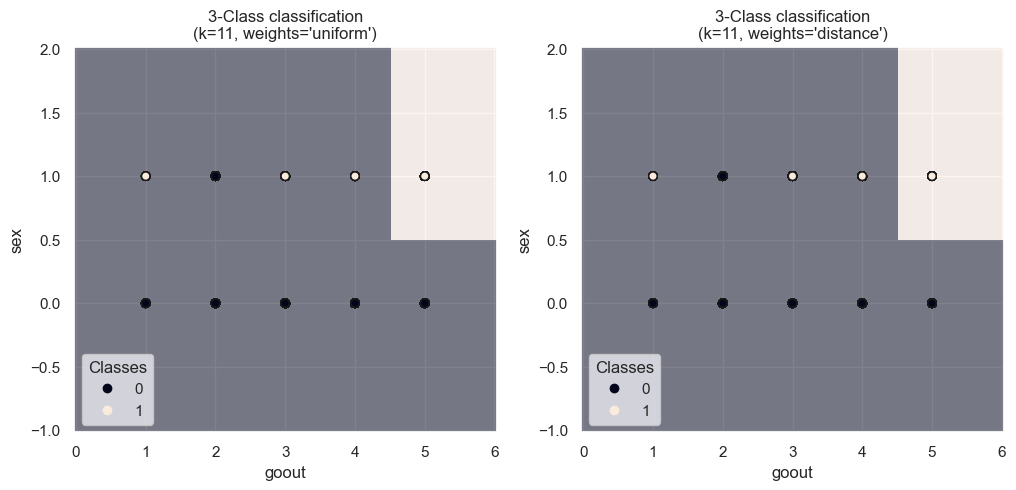

In [56]:
# Classification
X = students1[["goout", "sex"]]
y = students1['alc']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
)

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        students1['alc'].unique(),
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()


In [57]:
#knn with multiple predictors
list1 = [lifestyle_columns, char_columns, grades_columns, fam_columns]

for i in range(len(list1)):
    X = students1[list1[i]]
    y = students1['alc']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

    clf = Pipeline(
        steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
    )

    print(f"Using columns: {list1[i]}")
    clf.fit(X_train, y_train)
    print(f"Train score: {clf.score(X_train, y_train)}")
    print(f"Test score: {clf.score(X_test, y_test)}")
    print("")



Using columns: ['traveltime', 'studytime', 'freetime', 'goout', 'school', 'address', 'reason', 'activities', 'internet', 'romantic']
Train score: 0.8154050464807437
Test score: 0.7896825396825397

Using columns: ['age', 'health', 'sex']
Train score: 0.7941567065073041
Test score: 0.7341269841269841

Using columns: ['failures', 'absences', 'schoolsup', 'paid', 'nursery', 'higher']
Train score: 0.7861885790172642
Test score: 0.7857142857142857

Using columns: ['Medu', 'Fedu', 'famrel', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'guardian', 'famsup']
Train score: 0.7808764940239044
Test score: 0.7817460317460317



In [59]:
from sklearn import metrics

print(clf.predict(np.array([[5, 1]]).reshape(1, -1))) 

acc = metrics.accuracy_score(y_test, clf.predict(X_test))

print(f"The accuracy of the model is {acc}")

/Users/siri/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but StandardScaler is expecting 9 features as input.

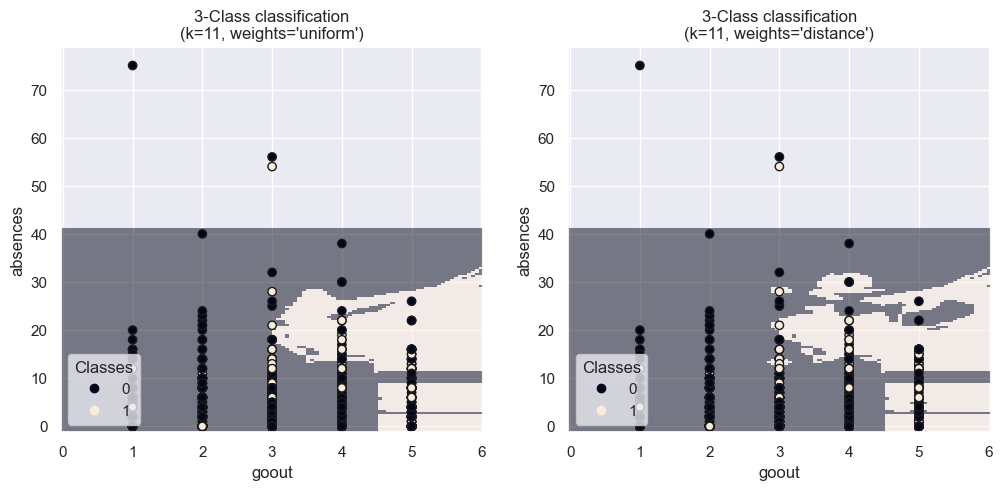

In [60]:
# Classification - duplicate for testing
X = students[["goout", "absences"]]
y = students['alc']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
)

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        students['alc'].unique(),
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

# SVM MODELLING

In [61]:
# SVM - Support Vector Machine Modelling SVM works by finding the optimal hyperplane that best separates 
# the classes in the feature space. The hyperplane is a decision boundary that maximizes 
# the margin between the classes.

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score


features = students1.drop(columns=['alc']) # Extract features by removing the target variable 'alc'
target = students1['alc'] # Define the target variable 'alc'

# Encode categorical variables
categorical_cols = features.select_dtypes(include=['object']).columns # Identify categorical columns
label_encoders = {} # Initialize dictionary to store label encoders for each categorical column
for col in categorical_cols:
    label_encoders[col] = LabelEncoder() # Initialize label encoder for each categorical column
    features[col] = label_encoders[col].fit_transform(features[col]) # Encode categorical column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler() # Initialize StandardScaler
X_train_scaled = scaler.fit_transform(X_train) # Fit and transform training features
X_test_scaled = scaler.transform(X_test) # Transform testing features using the same scaler

# Initialize SVM classifier
svm_classifier = SVC(kernel='rbf', random_state=42) 

# Train the SVM model
svm_classifier.fit(X_train_scaled, y_train)

# Predictions
y_pred = svm_classifier.predict(X_test_scaled)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
print("Accuracy:", accuracy)

# More detailed evaluation
print(classification_report(y_test, y_pred)) # Generate classification report

precision = metrics.precision_score(y_test, y_pred)
print("Precision: ", precision) # OVERALL precision

Accuracy: 0.8208955223880597
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       149
           1       0.94      0.33      0.49        52

    accuracy                           0.82       201
   macro avg       0.88      0.66      0.69       201
weighted avg       0.84      0.82      0.79       201

Precision:  0.9444444444444444


What these results mean

- Precision = Accuracy of poistive predictions
- 96% of the instances predicted as not consuming alcohol were actually not consuming alcohol.
-  98% of the instances predicted as consuming alcohol were actually consuming alcohol.

-Recall = the ability of the model to correctly identify positive instances.
        = True Positives / (True Positives + False Negatives)
- 99% of the actual instances of not consuming alcohol were correctly predicted by the model.
- 88% of the actual instances of consuming alcohol were correctly predicted by the model.

################################

In [66]:
# Import the train_test_split function from the scikit-learn library to divide data into training and test sets.
from sklearn.model_selection import train_test_split
# Import the GaussianNB classifier from the scikit-learn library which implements the Gaussian Naive Bayes algorithm.
from sklearn.naive_bayes import GaussianNB
# Import the accuracy_score function from scikit-learn to compute the accuracy of our model predictions.
from sklearn.metrics import accuracy_score

# Drop the column 'alc' from the DataFrame 'students1' and assign the resulting DataFrame to 'X'.
# This DataFrame 'X' now contains only the features that will be used to predict the target variable.
X = students1.drop(columns=['alc'])
# Assign the column 'alc' from the DataFrame 'students' to 'y'. This series 'y' contains the target variable.
y = students['alc']

# Use the train_test_split function to split 'X' and 'y' into training and test sets.
# 30% of the data is allocated to the test set ('test_size=0.3') and the split is reproducible ('random_state=42').
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create an instance of the GaussianNB class. This instance 'gnb' is the classifier that will be trained.
gnb = GaussianNB()

# Fit the Gaussian Naive Bayes classifier 'gnb' on the training data 'X_train' and 'y_train'.
gnb.fit(X_train, y_train)

# Use the trained classifier 'gnb' to make predictions on the test data 'X_test'.
y_pred = gnb.predict(X_test)

# Calculate the accuracy of the predictions 'y_pred' by comparing them with the actual labels 'y_test'.
accuracy = accuracy_score(y_test, y_pred)
# Print the computed accuracy.
print(f"Accuracy: {accuracy}")

# Print the predictions made on the test data.
print("Predictions:", y_pred)

# Iterate over the actual labels and predicted labels, and print each pair.
for actual, predicted in zip(y_test, y_pred):
    print(f"Actual: {actual}, Predicted: {predicted}")

# Calculate the number of correct predictions by comparing the predicted labels 'y_pred' directly with 'y_test'.
correct_predictions = np.sum(y_pred == y_test)
# Calculate the number of incorrect predictions by checking where 'y_pred' does not equal 'y_test'.
wrong_predictions = np.sum(y_pred != y_test)

# Print the number of correct predictions.
print(f"Correct Predictions: {correct_predictions}")
# Print the number of wrong predictions.
print(f"Wrong Predictions: {wrong_predictions}")

# Retrieve the list of predictor variables from the DataFrame 'X' and print them.
predictor_variables = X.columns.tolist()
print("Predictor Variables:", predictor_variables)


Accuracy: 0.7582781456953642
Predictions: [1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0
 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Actual: 0, Predicted: 1
Actual: 0, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 1
Actual: 0, Predicted: 1
Actual: 1, Predicted: 0
Actual: 1, Predicted: 0
Actual: 

- The output tells us the accuracy using the number of correct predictions divided by the total number of predictions made.
- These are instances where the model's predicted value (output) matches the actual value from the data.
- For example, if the actual label for a student's alcohol consumption is 0 (not consuming alcohol above a certain threshold) and the model also predicts 0, this is counted as a correct prediction.
- Similarly, if the actual label is 1 (consuming alcohol above the threshold) and the prediction is also 1, this is also a correct prediction.
- Correct predictions contribute positively to the model's accuracy and indicate that the model has effectively learned the underlying patterns